In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import random
import timeit
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
RANDOM_SEED = 1234
BATCH_SIZE = 512
EPOCHS = 100
LEARNING_RATE = 0.001
NUM_CLASSES = 10
PATCH_SIZE = 4
IMG_SIZE = 28
IN_CHANNELS = 1
NUM_HEADS = 8
DROPOUT = 0.001
HIDDEN_DIM = 768
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9, 0.999)
ACTIVATION="gelu"
NUM_ENCODERS = 4
EMBED_DIM = (PATCH_SIZE ** 2) * IN_CHANNELS # 16
NUM_PATCH = (IMG_SIZE // PATCH_SIZE) ** 2 # 49
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patch, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size),
            nn.Flatten(2)
        )
        self.cls_token = nn.Parameter(torch.randn(size=(1, in_channels, embed_dim)), requires_grad=True)
        self.position_embedding = nn.Parameter(torch.randn(size=(1, num_patch+1, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = self.patcher(x).permute(0, 2, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = self.position_embedding + x
        x = self.dropout(x)
        
        return x

model = PatchEmbedding(EMBED_DIM, PATCH_SIZE, NUM_PATCH, DROPOUT, IN_CHANNELS)
model.to(device)
x = torch.randn(512, 1, 28, 28).to(device)
print(model(x).shape)

torch.Size([512, 50, 16])


In [5]:
class ViT(nn.Module):
    def __init__(self, num_patch, img_size, num_classes, patch_size, embed_dim, num_heads, num_encoders, hidden_dim, dropout, activation, in_channels):
        super().__init__()
        self.embedding_block = PatchEmbedding(embed_dim, patch_size, num_patch, dropout, in_channels)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, activation=activation, batch_first=True, norm_first=True)
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )
    
    def forward(self, x):
        x = self.embedding_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0, :])
        return x

model = ViT(NUM_PATCH, IMG_SIZE, NUM_CLASSES, PATCH_SIZE, EMBED_DIM, NUM_HEADS, NUM_ENCODERS, HIDDEN_DIM, DROPOUT, ACTIVATION, IN_CHANNELS)
model.to(device)
x = torch.randn(512, 1, 28, 28).to(device)
print(model(x).shape)

torch.Size([512, 10])


In [6]:
train_df = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test_df = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

In [7]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=RANDOM_SEED, shuffle=True)

In [10]:
class Train_Dataset(Dataset):
    def __init__(self, images, labels, indices):
        self.images = images
        self.labels = labels
        self.indices = indices
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize([0.5],[0.5])
        ])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indices[idx]
        image = self.transform(image)
        
        return {"image": image, "label": label, "index": index}

class Test_Dataset(Dataset):
    def __init__(self, images, indicies):
        self.images = images
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        index = self.indicies[idx]
        image = self.transform(image)
        
        return {"image": image, "index": index}

37800
4200
28000


<Figure size 640x480 with 0 Axes>

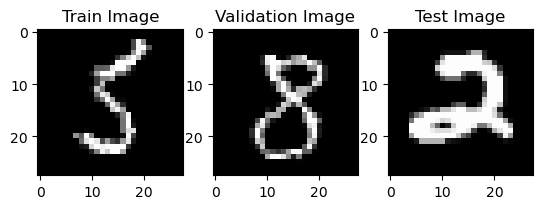

In [11]:
plt.figure()
f, axes = plt.subplots(1, 3)

train_ds = Train_Dataset(train_df.iloc[:, 1:].values.astype(np.uint8), train_df.iloc[:, 0].values, train_df.index.values)
print(len(train_ds))
axes[0].imshow(train_ds[0]["image"].squeeze(), cmap="gray")
axes[0].set_title("Train Image")

val_ds = Train_Dataset(val_df.iloc[:, 1:].values.astype(np.uint8), val_df.iloc[:, 0].values, val_df.index.values)
print(len(val_ds))
axes[1].imshow(val_ds[0]["image"].squeeze(), cmap="gray")
axes[1].set_title("Validation Image")

test_ds = Test_Dataset(test_df.iloc[:, 0:].values.astype(np.uint8), test_df.index.values)
print(len(test_ds))
axes[2].imshow(test_ds[0]["image"].squeeze(), cmap="gray")
axes[2].set_title("Test Image")

plt.show()

In [12]:
train_dataloader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)

for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    model.train()
    train_labels = []
    train_preds = []
    cost = 0
    for idx, data in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = data["image"].float().to(device)
        label = data["label"].type(torch.uint8).to(device)
        y_pred = model(img)
        y_pred_label = torch.argmax(y_pred, dim=1)
        train_labels.extend(label.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())
        
        loss = loss_func(y_pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cost += loss.item()
    train_cost = cost / (1+idx)
    
    model.eval()
    val_labels = []
    val_preds = []
    val_cost = 0
    with torch.no_grad():
        for idx, data in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = data["image"].float().to(device)
            label = data["label"].type(torch.uint8).to(device)
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)
            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())
            
            loss = loss_func(y_pred, label)
            val_cost += loss
    val_cost = val_cost / (1+idx)
    
    print("-"*30)
    print(f"Train Loss EPOCH {epoch+1}: {train_cost:.4f}")
    print(f"Valid Loss EPOCH {epoch+1}: {val_cost:.4f}")
    print(f"Train Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(train_preds, train_labels) if x == y) / len(train_labels):.4f}")
    print(f"Valid Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(val_preds, val_labels) if x == y) / len(val_labels):.4f}")
    print("-"*30)

100%|██████████| 9/9 [00:01<00:00,  5.73it/s]


------------------------------
Train Loss EPOCH 1: 2.3049
Valid Loss EPOCH 1: 2.2956


  1%|          | 1/100 [00:19<31:44, 19.24s/it]

Train Accuracy EPOCH 1: 0.1165
Valid Accuracy EPOCH 1: 0.1455
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.80it/s]


------------------------------
Train Loss EPOCH 2: 2.0130
Valid Loss EPOCH 2: 1.5828


  2%|▏         | 2/100 [00:38<31:10, 19.09s/it]

Train Accuracy EPOCH 2: 0.2660
Valid Accuracy EPOCH 2: 0.4586
------------------------------


100%|██████████| 9/9 [00:01<00:00,  4.92it/s]


------------------------------
Train Loss EPOCH 3: 1.1458
Valid Loss EPOCH 3: 0.8490


  3%|▎         | 3/100 [00:57<30:47, 19.05s/it]

Train Accuracy EPOCH 3: 0.6354
Valid Accuracy EPOCH 3: 0.7405
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.54it/s]


------------------------------
Train Loss EPOCH 4: 0.7278
Valid Loss EPOCH 4: 0.6734


  4%|▍         | 4/100 [01:16<30:25, 19.01s/it]

Train Accuracy EPOCH 4: 0.7658
Valid Accuracy EPOCH 4: 0.7774
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.72it/s]


------------------------------
Train Loss EPOCH 5: 0.5691
Valid Loss EPOCH 5: 0.5003


  5%|▌         | 5/100 [01:35<30:08, 19.04s/it]

Train Accuracy EPOCH 5: 0.8183
Valid Accuracy EPOCH 5: 0.8410
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.82it/s]


------------------------------
Train Loss EPOCH 6: 0.4491
Valid Loss EPOCH 6: 0.4499


  6%|▌         | 6/100 [01:54<29:51, 19.06s/it]

Train Accuracy EPOCH 6: 0.8614
Valid Accuracy EPOCH 6: 0.8624
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.80it/s]


------------------------------
Train Loss EPOCH 7: 0.3729
Valid Loss EPOCH 7: 0.3624


  7%|▋         | 7/100 [02:13<29:26, 18.99s/it]

Train Accuracy EPOCH 7: 0.8863
Valid Accuracy EPOCH 7: 0.8900
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.60it/s]


------------------------------
Train Loss EPOCH 8: 0.3177
Valid Loss EPOCH 8: 0.3252


  8%|▊         | 8/100 [02:32<29:13, 19.06s/it]

Train Accuracy EPOCH 8: 0.9027
Valid Accuracy EPOCH 8: 0.8967
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.67it/s]


------------------------------
Train Loss EPOCH 9: 0.2966
Valid Loss EPOCH 9: 0.2941


  9%|▉         | 9/100 [02:51<28:57, 19.09s/it]

Train Accuracy EPOCH 9: 0.9086
Valid Accuracy EPOCH 9: 0.9114
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.22it/s]


------------------------------
Train Loss EPOCH 10: 0.2694
Valid Loss EPOCH 10: 0.2931


 10%|█         | 10/100 [03:10<28:30, 19.00s/it]

Train Accuracy EPOCH 10: 0.9171
Valid Accuracy EPOCH 10: 0.9100
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.72it/s]


------------------------------
Train Loss EPOCH 11: 0.2595
Valid Loss EPOCH 11: 0.2947


 11%|█         | 11/100 [03:29<28:01, 18.90s/it]

Train Accuracy EPOCH 11: 0.9192
Valid Accuracy EPOCH 11: 0.9081
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.70it/s]


------------------------------
Train Loss EPOCH 12: 0.2357
Valid Loss EPOCH 12: 0.2478


 12%|█▏        | 12/100 [03:47<27:41, 18.88s/it]

Train Accuracy EPOCH 12: 0.9263
Valid Accuracy EPOCH 12: 0.9238
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.72it/s]


------------------------------
Train Loss EPOCH 13: 0.2212
Valid Loss EPOCH 13: 0.2263


 13%|█▎        | 13/100 [04:06<27:22, 18.88s/it]

Train Accuracy EPOCH 13: 0.9316
Valid Accuracy EPOCH 13: 0.9326
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.56it/s]


------------------------------
Train Loss EPOCH 14: 0.2056
Valid Loss EPOCH 14: 0.2118


 14%|█▍        | 14/100 [04:25<27:02, 18.86s/it]

Train Accuracy EPOCH 14: 0.9370
Valid Accuracy EPOCH 14: 0.9295
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.81it/s]


------------------------------
Train Loss EPOCH 15: 0.2006
Valid Loss EPOCH 15: 0.2047


 15%|█▌        | 15/100 [04:44<26:45, 18.89s/it]

Train Accuracy EPOCH 15: 0.9375
Valid Accuracy EPOCH 15: 0.9336
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.84it/s]


------------------------------
Train Loss EPOCH 16: 0.1858
Valid Loss EPOCH 16: 0.1800


 16%|█▌        | 16/100 [05:03<26:28, 18.91s/it]

Train Accuracy EPOCH 16: 0.9417
Valid Accuracy EPOCH 16: 0.9386
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.22it/s]


------------------------------
Train Loss EPOCH 17: 0.1815
Valid Loss EPOCH 17: 0.1965


 17%|█▋        | 17/100 [05:22<26:12, 18.94s/it]

Train Accuracy EPOCH 17: 0.9429
Valid Accuracy EPOCH 17: 0.9390
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.89it/s]


------------------------------
Train Loss EPOCH 18: 0.1704
Valid Loss EPOCH 18: 0.1996


 18%|█▊        | 18/100 [05:41<25:44, 18.84s/it]

Train Accuracy EPOCH 18: 0.9462
Valid Accuracy EPOCH 18: 0.9381
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.89it/s]


------------------------------
Train Loss EPOCH 19: 0.1695
Valid Loss EPOCH 19: 0.1714


 19%|█▉        | 19/100 [05:59<25:18, 18.74s/it]

Train Accuracy EPOCH 19: 0.9460
Valid Accuracy EPOCH 19: 0.9455
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.91it/s]


------------------------------
Train Loss EPOCH 20: 0.1599
Valid Loss EPOCH 20: 0.1716


 20%|██        | 20/100 [06:18<24:56, 18.70s/it]

Train Accuracy EPOCH 20: 0.9492
Valid Accuracy EPOCH 20: 0.9431
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.65it/s]


------------------------------
Train Loss EPOCH 21: 0.1546
Valid Loss EPOCH 21: 0.1542


 21%|██        | 21/100 [06:36<24:30, 18.62s/it]

Train Accuracy EPOCH 21: 0.9519
Valid Accuracy EPOCH 21: 0.9505
------------------------------


100%|██████████| 9/9 [00:01<00:00,  6.01it/s]


------------------------------
Train Loss EPOCH 22: 0.1575
Valid Loss EPOCH 22: 0.1505


 22%|██▏       | 22/100 [06:55<24:12, 18.62s/it]

Train Accuracy EPOCH 22: 0.9501
Valid Accuracy EPOCH 22: 0.9531
------------------------------


100%|██████████| 9/9 [00:01<00:00,  6.00it/s]


------------------------------
Train Loss EPOCH 23: 0.1449
Valid Loss EPOCH 23: 0.1869


 23%|██▎       | 23/100 [07:13<23:53, 18.61s/it]

Train Accuracy EPOCH 23: 0.9533
Valid Accuracy EPOCH 23: 0.9419
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.71it/s]


------------------------------
Train Loss EPOCH 24: 0.1437
Valid Loss EPOCH 24: 0.1568


 24%|██▍       | 24/100 [07:32<23:31, 18.57s/it]

Train Accuracy EPOCH 24: 0.9545
Valid Accuracy EPOCH 24: 0.9507
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.95it/s]


------------------------------
Train Loss EPOCH 25: 0.1389
Valid Loss EPOCH 25: 0.1639


 25%|██▌       | 25/100 [07:51<23:17, 18.63s/it]

Train Accuracy EPOCH 25: 0.9556
Valid Accuracy EPOCH 25: 0.9462
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.69it/s]


------------------------------
Train Loss EPOCH 26: 0.1360
Valid Loss EPOCH 26: 0.1466


 26%|██▌       | 26/100 [08:09<22:58, 18.63s/it]

Train Accuracy EPOCH 26: 0.9562
Valid Accuracy EPOCH 26: 0.9519
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.98it/s]


------------------------------
Train Loss EPOCH 27: 0.1353
Valid Loss EPOCH 27: 0.1498


 27%|██▋       | 27/100 [08:28<22:38, 18.61s/it]

Train Accuracy EPOCH 27: 0.9568
Valid Accuracy EPOCH 27: 0.9514
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.83it/s]


------------------------------
Train Loss EPOCH 28: 0.1284
Valid Loss EPOCH 28: 0.1481


 28%|██▊       | 28/100 [08:46<22:17, 18.57s/it]

Train Accuracy EPOCH 28: 0.9593
Valid Accuracy EPOCH 28: 0.9560
------------------------------


100%|██████████| 9/9 [00:01<00:00,  6.06it/s]


------------------------------
Train Loss EPOCH 29: 0.1294
Valid Loss EPOCH 29: 0.1277


 29%|██▉       | 29/100 [09:05<21:55, 18.52s/it]

Train Accuracy EPOCH 29: 0.9598
Valid Accuracy EPOCH 29: 0.9588
------------------------------


100%|██████████| 9/9 [00:01<00:00,  6.00it/s]


------------------------------
Train Loss EPOCH 30: 0.1251
Valid Loss EPOCH 30: 0.1270


 30%|███       | 30/100 [09:23<21:36, 18.52s/it]

Train Accuracy EPOCH 30: 0.9602
Valid Accuracy EPOCH 30: 0.9612
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.79it/s]


------------------------------
Train Loss EPOCH 31: 0.1215
Valid Loss EPOCH 31: 0.1351


 31%|███       | 31/100 [09:42<21:16, 18.51s/it]

Train Accuracy EPOCH 31: 0.9610
Valid Accuracy EPOCH 31: 0.9579
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.97it/s]


------------------------------
Train Loss EPOCH 32: 0.1205
Valid Loss EPOCH 32: 0.1286


 32%|███▏      | 32/100 [10:00<20:56, 18.48s/it]

Train Accuracy EPOCH 32: 0.9610
Valid Accuracy EPOCH 32: 0.9581
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.96it/s]


------------------------------
Train Loss EPOCH 33: 0.1144
Valid Loss EPOCH 33: 0.1284


 33%|███▎      | 33/100 [10:19<20:42, 18.54s/it]

Train Accuracy EPOCH 33: 0.9632
Valid Accuracy EPOCH 33: 0.9600
------------------------------


100%|██████████| 9/9 [00:01<00:00,  6.10it/s]


------------------------------
Train Loss EPOCH 34: 0.1163
Valid Loss EPOCH 34: 0.1317


 34%|███▍      | 34/100 [10:37<20:21, 18.51s/it]

Train Accuracy EPOCH 34: 0.9622
Valid Accuracy EPOCH 34: 0.9576
------------------------------


100%|██████████| 9/9 [00:01<00:00,  6.00it/s]


------------------------------
Train Loss EPOCH 35: 0.1066
Valid Loss EPOCH 35: 0.1210


 35%|███▌      | 35/100 [10:56<19:59, 18.46s/it]

Train Accuracy EPOCH 35: 0.9649
Valid Accuracy EPOCH 35: 0.9593
------------------------------


100%|██████████| 9/9 [00:01<00:00,  6.04it/s]


------------------------------
Train Loss EPOCH 36: 0.1071
Valid Loss EPOCH 36: 0.1355


 36%|███▌      | 36/100 [11:14<19:43, 18.49s/it]

Train Accuracy EPOCH 36: 0.9659
Valid Accuracy EPOCH 36: 0.9588
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.87it/s]


------------------------------
Train Loss EPOCH 37: 0.1118
Valid Loss EPOCH 37: 0.1245


 37%|███▋      | 37/100 [11:33<19:26, 18.52s/it]

Train Accuracy EPOCH 37: 0.9646
Valid Accuracy EPOCH 37: 0.9602
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.97it/s]


------------------------------
Train Loss EPOCH 38: 0.1026
Valid Loss EPOCH 38: 0.1199


 38%|███▊      | 38/100 [11:51<19:06, 18.50s/it]

Train Accuracy EPOCH 38: 0.9671
Valid Accuracy EPOCH 38: 0.9595
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.91it/s]


------------------------------
Train Loss EPOCH 39: 0.1096
Valid Loss EPOCH 39: 0.1124


 39%|███▉      | 39/100 [12:10<18:45, 18.46s/it]

Train Accuracy EPOCH 39: 0.9654
Valid Accuracy EPOCH 39: 0.9652
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.21it/s]


------------------------------
Train Loss EPOCH 40: 0.1009
Valid Loss EPOCH 40: 0.1058


 40%|████      | 40/100 [12:28<18:29, 18.49s/it]

Train Accuracy EPOCH 40: 0.9675
Valid Accuracy EPOCH 40: 0.9662
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.66it/s]


------------------------------
Train Loss EPOCH 41: 0.1003
Valid Loss EPOCH 41: 0.1343


 41%|████      | 41/100 [12:46<18:08, 18.46s/it]

Train Accuracy EPOCH 41: 0.9683
Valid Accuracy EPOCH 41: 0.9607
------------------------------


100%|██████████| 9/9 [00:01<00:00,  6.10it/s]


------------------------------
Train Loss EPOCH 42: 0.0959
Valid Loss EPOCH 42: 0.1178


 42%|████▏     | 42/100 [13:05<17:50, 18.45s/it]

Train Accuracy EPOCH 42: 0.9687
Valid Accuracy EPOCH 42: 0.9607
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.99it/s]


------------------------------
Train Loss EPOCH 43: 0.0968
Valid Loss EPOCH 43: 0.1139


 43%|████▎     | 43/100 [13:24<17:39, 18.59s/it]

Train Accuracy EPOCH 43: 0.9687
Valid Accuracy EPOCH 43: 0.9662
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.98it/s]


------------------------------
Train Loss EPOCH 44: 0.1024
Valid Loss EPOCH 44: 0.1017


 44%|████▍     | 44/100 [13:42<17:18, 18.55s/it]

Train Accuracy EPOCH 44: 0.9673
Valid Accuracy EPOCH 44: 0.9671
------------------------------


100%|██████████| 9/9 [00:01<00:00,  6.01it/s]


------------------------------
Train Loss EPOCH 45: 0.0905
Valid Loss EPOCH 45: 0.1337


 45%|████▌     | 45/100 [14:01<17:01, 18.57s/it]

Train Accuracy EPOCH 45: 0.9709
Valid Accuracy EPOCH 45: 0.9621
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.62it/s]


------------------------------
Train Loss EPOCH 46: 0.0915
Valid Loss EPOCH 46: 0.1120


 46%|████▌     | 46/100 [14:19<16:42, 18.57s/it]

Train Accuracy EPOCH 46: 0.9711
Valid Accuracy EPOCH 46: 0.9650
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.97it/s]


------------------------------
Train Loss EPOCH 47: 0.0927
Valid Loss EPOCH 47: 0.1057


 47%|████▋     | 47/100 [14:38<16:21, 18.52s/it]

Train Accuracy EPOCH 47: 0.9702
Valid Accuracy EPOCH 47: 0.9667
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.99it/s]


------------------------------
Train Loss EPOCH 48: 0.0861
Valid Loss EPOCH 48: 0.1214


 48%|████▊     | 48/100 [14:56<16:01, 18.48s/it]

Train Accuracy EPOCH 48: 0.9725
Valid Accuracy EPOCH 48: 0.9629
------------------------------


100%|██████████| 9/9 [00:01<00:00,  6.12it/s]


------------------------------
Train Loss EPOCH 49: 0.0877
Valid Loss EPOCH 49: 0.1080


 49%|████▉     | 49/100 [15:15<15:41, 18.46s/it]

Train Accuracy EPOCH 49: 0.9720
Valid Accuracy EPOCH 49: 0.9664
------------------------------


100%|██████████| 9/9 [00:01<00:00,  6.07it/s]


------------------------------
Train Loss EPOCH 50: 0.0855
Valid Loss EPOCH 50: 0.1414


 50%|█████     | 50/100 [15:33<15:22, 18.45s/it]

Train Accuracy EPOCH 50: 0.9724
Valid Accuracy EPOCH 50: 0.9612
------------------------------


100%|██████████| 9/9 [00:01<00:00,  6.20it/s]


------------------------------
Train Loss EPOCH 51: 0.0838
Valid Loss EPOCH 51: 0.1023


 51%|█████     | 51/100 [15:51<14:57, 18.31s/it]

Train Accuracy EPOCH 51: 0.9729
Valid Accuracy EPOCH 51: 0.9662
------------------------------


100%|██████████| 9/9 [00:01<00:00,  6.15it/s]


------------------------------
Train Loss EPOCH 52: 0.0827
Valid Loss EPOCH 52: 0.0942


 52%|█████▏    | 52/100 [16:09<14:38, 18.30s/it]

Train Accuracy EPOCH 52: 0.9733
Valid Accuracy EPOCH 52: 0.9693
------------------------------


100%|██████████| 9/9 [00:01<00:00,  6.15it/s]


------------------------------
Train Loss EPOCH 53: 0.0827
Valid Loss EPOCH 53: 0.1148


 53%|█████▎    | 53/100 [16:28<14:22, 18.35s/it]

Train Accuracy EPOCH 53: 0.9737
Valid Accuracy EPOCH 53: 0.9640
------------------------------


100%|██████████| 9/9 [00:01<00:00,  6.02it/s]


------------------------------
Train Loss EPOCH 54: 0.0867
Valid Loss EPOCH 54: 0.1023


 54%|█████▍    | 54/100 [16:46<13:59, 18.26s/it]

Train Accuracy EPOCH 54: 0.9727
Valid Accuracy EPOCH 54: 0.9657
------------------------------


100%|██████████| 9/9 [00:01<00:00,  6.18it/s]


------------------------------
Train Loss EPOCH 55: 0.0850
Valid Loss EPOCH 55: 0.1093


 55%|█████▌    | 55/100 [17:04<13:40, 18.24s/it]

Train Accuracy EPOCH 55: 0.9730
Valid Accuracy EPOCH 55: 0.9683
------------------------------


100%|██████████| 9/9 [00:01<00:00,  6.18it/s]


------------------------------
Train Loss EPOCH 56: 0.0794
Valid Loss EPOCH 56: 0.0938


 56%|█████▌    | 56/100 [17:22<13:20, 18.20s/it]

Train Accuracy EPOCH 56: 0.9740
Valid Accuracy EPOCH 56: 0.9695
------------------------------


100%|██████████| 9/9 [00:01<00:00,  6.08it/s]


------------------------------
Train Loss EPOCH 57: 0.0780
Valid Loss EPOCH 57: 0.0940


 57%|█████▋    | 57/100 [17:41<13:04, 18.25s/it]

Train Accuracy EPOCH 57: 0.9743
Valid Accuracy EPOCH 57: 0.9721
------------------------------


100%|██████████| 9/9 [00:01<00:00,  6.00it/s]


------------------------------
Train Loss EPOCH 58: 0.0750
Valid Loss EPOCH 58: 0.1001


 58%|█████▊    | 58/100 [17:59<12:44, 18.21s/it]

Train Accuracy EPOCH 58: 0.9752
Valid Accuracy EPOCH 58: 0.9693
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.90it/s]


------------------------------
Train Loss EPOCH 59: 0.0748
Valid Loss EPOCH 59: 0.0872


 59%|█████▉    | 59/100 [18:17<12:29, 18.27s/it]

Train Accuracy EPOCH 59: 0.9762
Valid Accuracy EPOCH 59: 0.9717
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.33it/s]


------------------------------
Train Loss EPOCH 60: 0.0762
Valid Loss EPOCH 60: 0.0949


 60%|██████    | 60/100 [18:35<12:12, 18.32s/it]

Train Accuracy EPOCH 60: 0.9749
Valid Accuracy EPOCH 60: 0.9700
------------------------------


100%|██████████| 9/9 [00:01<00:00,  6.00it/s]


------------------------------
Train Loss EPOCH 61: 0.0769
Valid Loss EPOCH 61: 0.1063


 61%|██████    | 61/100 [18:54<11:51, 18.25s/it]

Train Accuracy EPOCH 61: 0.9738
Valid Accuracy EPOCH 61: 0.9655
------------------------------


100%|██████████| 9/9 [00:01<00:00,  6.03it/s]


------------------------------
Train Loss EPOCH 62: 0.0738
Valid Loss EPOCH 62: 0.1027


 62%|██████▏   | 62/100 [19:12<11:36, 18.32s/it]

Train Accuracy EPOCH 62: 0.9765
Valid Accuracy EPOCH 62: 0.9674
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.99it/s]


------------------------------
Train Loss EPOCH 63: 0.0713
Valid Loss EPOCH 63: 0.1171


 63%|██████▎   | 63/100 [19:30<11:18, 18.33s/it]

Train Accuracy EPOCH 63: 0.9766
Valid Accuracy EPOCH 63: 0.9645
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.95it/s]


------------------------------
Train Loss EPOCH 64: 0.0748
Valid Loss EPOCH 64: 0.0929


 64%|██████▍   | 64/100 [19:49<11:01, 18.38s/it]

Train Accuracy EPOCH 64: 0.9760
Valid Accuracy EPOCH 64: 0.9688
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.91it/s]


------------------------------
Train Loss EPOCH 65: 0.0767
Valid Loss EPOCH 65: 0.0919


 65%|██████▌   | 65/100 [20:08<10:45, 18.44s/it]

Train Accuracy EPOCH 65: 0.9749
Valid Accuracy EPOCH 65: 0.9693
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.88it/s]


------------------------------
Train Loss EPOCH 66: 0.0704
Valid Loss EPOCH 66: 0.0951


 66%|██████▌   | 66/100 [20:26<10:29, 18.52s/it]

Train Accuracy EPOCH 66: 0.9771
Valid Accuracy EPOCH 66: 0.9693
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.90it/s]


------------------------------
Train Loss EPOCH 67: 0.0689
Valid Loss EPOCH 67: 0.0884


 67%|██████▋   | 67/100 [20:45<10:11, 18.52s/it]

Train Accuracy EPOCH 67: 0.9772
Valid Accuracy EPOCH 67: 0.9714
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.87it/s]


------------------------------
Train Loss EPOCH 68: 0.0656
Valid Loss EPOCH 68: 0.0952


 68%|██████▊   | 68/100 [21:03<09:54, 18.57s/it]

Train Accuracy EPOCH 68: 0.9792
Valid Accuracy EPOCH 68: 0.9707
------------------------------


100%|██████████| 9/9 [00:01<00:00,  6.00it/s]


------------------------------
Train Loss EPOCH 69: 0.0698
Valid Loss EPOCH 69: 0.0872


 69%|██████▉   | 69/100 [21:22<09:35, 18.58s/it]

Train Accuracy EPOCH 69: 0.9769
Valid Accuracy EPOCH 69: 0.9724
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.92it/s]


------------------------------
Train Loss EPOCH 70: 0.0712
Valid Loss EPOCH 70: 0.1090


 70%|███████   | 70/100 [21:41<09:18, 18.61s/it]

Train Accuracy EPOCH 70: 0.9776
Valid Accuracy EPOCH 70: 0.9693
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.85it/s]


------------------------------
Train Loss EPOCH 71: 0.0686
Valid Loss EPOCH 71: 0.0930


 71%|███████   | 71/100 [21:59<08:57, 18.53s/it]

Train Accuracy EPOCH 71: 0.9772
Valid Accuracy EPOCH 71: 0.9683
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.90it/s]


------------------------------
Train Loss EPOCH 72: 0.0637
Valid Loss EPOCH 72: 0.0944


 72%|███████▏  | 72/100 [22:18<08:41, 18.61s/it]

Train Accuracy EPOCH 72: 0.9791
Valid Accuracy EPOCH 72: 0.9710
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.86it/s]


------------------------------
Train Loss EPOCH 73: 0.0673
Valid Loss EPOCH 73: 0.0825


 73%|███████▎  | 73/100 [22:36<08:22, 18.60s/it]

Train Accuracy EPOCH 73: 0.9776
Valid Accuracy EPOCH 73: 0.9750
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.83it/s]


------------------------------
Train Loss EPOCH 74: 0.0649
Valid Loss EPOCH 74: 0.0902


 74%|███████▍  | 74/100 [22:55<08:03, 18.61s/it]

Train Accuracy EPOCH 74: 0.9788
Valid Accuracy EPOCH 74: 0.9714
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.90it/s]


------------------------------
Train Loss EPOCH 75: 0.0622
Valid Loss EPOCH 75: 0.0931


 75%|███████▌  | 75/100 [23:14<07:47, 18.69s/it]

Train Accuracy EPOCH 75: 0.9784
Valid Accuracy EPOCH 75: 0.9698
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.95it/s]


------------------------------
Train Loss EPOCH 76: 0.0648
Valid Loss EPOCH 76: 0.0896


 76%|███████▌  | 76/100 [23:33<07:29, 18.73s/it]

Train Accuracy EPOCH 76: 0.9789
Valid Accuracy EPOCH 76: 0.9740
------------------------------


100%|██████████| 9/9 [00:01<00:00,  6.07it/s]


------------------------------
Train Loss EPOCH 77: 0.0629
Valid Loss EPOCH 77: 0.0850


 77%|███████▋  | 77/100 [23:51<07:10, 18.72s/it]

Train Accuracy EPOCH 77: 0.9792
Valid Accuracy EPOCH 77: 0.9700
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.84it/s]


------------------------------
Train Loss EPOCH 78: 0.0598
Valid Loss EPOCH 78: 0.0935


 78%|███████▊  | 78/100 [24:10<06:50, 18.64s/it]

Train Accuracy EPOCH 78: 0.9799
Valid Accuracy EPOCH 78: 0.9719
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.98it/s]


------------------------------
Train Loss EPOCH 79: 0.0632
Valid Loss EPOCH 79: 0.0828


 79%|███████▉  | 79/100 [24:29<06:32, 18.67s/it]

Train Accuracy EPOCH 79: 0.9792
Valid Accuracy EPOCH 79: 0.9748
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.02it/s]


------------------------------
Train Loss EPOCH 80: 0.0584
Valid Loss EPOCH 80: 0.0873


 80%|████████  | 80/100 [24:47<06:13, 18.69s/it]

Train Accuracy EPOCH 80: 0.9806
Valid Accuracy EPOCH 80: 0.9707
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.80it/s]


------------------------------
Train Loss EPOCH 81: 0.0600
Valid Loss EPOCH 81: 0.0862


 81%|████████  | 81/100 [25:06<05:53, 18.62s/it]

Train Accuracy EPOCH 81: 0.9799
Valid Accuracy EPOCH 81: 0.9721
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.98it/s]


------------------------------
Train Loss EPOCH 82: 0.0592
Valid Loss EPOCH 82: 0.0804


 82%|████████▏ | 82/100 [25:25<05:36, 18.71s/it]

Train Accuracy EPOCH 82: 0.9813
Valid Accuracy EPOCH 82: 0.9743
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.77it/s]


------------------------------
Train Loss EPOCH 83: 0.0602
Valid Loss EPOCH 83: 0.0873


 83%|████████▎ | 83/100 [25:43<05:17, 18.70s/it]

Train Accuracy EPOCH 83: 0.9803
Valid Accuracy EPOCH 83: 0.9733
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.99it/s]


------------------------------
Train Loss EPOCH 84: 0.0577
Valid Loss EPOCH 84: 0.0866


 84%|████████▍ | 84/100 [26:02<04:58, 18.63s/it]

Train Accuracy EPOCH 84: 0.9805
Valid Accuracy EPOCH 84: 0.9724
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.18it/s]


------------------------------
Train Loss EPOCH 85: 0.0602
Valid Loss EPOCH 85: 0.0828


 85%|████████▌ | 85/100 [26:21<04:40, 18.73s/it]

Train Accuracy EPOCH 85: 0.9802
Valid Accuracy EPOCH 85: 0.9738
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.59it/s]


------------------------------
Train Loss EPOCH 86: 0.0542
Valid Loss EPOCH 86: 0.0875


 86%|████████▌ | 86/100 [26:39<04:21, 18.70s/it]

Train Accuracy EPOCH 86: 0.9817
Valid Accuracy EPOCH 86: 0.9748
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.13it/s]


------------------------------
Train Loss EPOCH 87: 0.0571
Valid Loss EPOCH 87: 0.0898


 87%|████████▋ | 87/100 [26:58<04:04, 18.79s/it]

Train Accuracy EPOCH 87: 0.9811
Valid Accuracy EPOCH 87: 0.9743
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.82it/s]


------------------------------
Train Loss EPOCH 88: 0.0561
Valid Loss EPOCH 88: 0.0731


 88%|████████▊ | 88/100 [27:17<03:44, 18.70s/it]

Train Accuracy EPOCH 88: 0.9812
Valid Accuracy EPOCH 88: 0.9750
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.87it/s]


------------------------------
Train Loss EPOCH 89: 0.0549
Valid Loss EPOCH 89: 0.0916


 89%|████████▉ | 89/100 [27:36<03:25, 18.70s/it]

Train Accuracy EPOCH 89: 0.9820
Valid Accuracy EPOCH 89: 0.9748
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.75it/s]


------------------------------
Train Loss EPOCH 90: 0.0587
Valid Loss EPOCH 90: 0.0757


 90%|█████████ | 90/100 [27:54<03:07, 18.72s/it]

Train Accuracy EPOCH 90: 0.9798
Valid Accuracy EPOCH 90: 0.9788
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.92it/s]


------------------------------
Train Loss EPOCH 91: 0.0570
Valid Loss EPOCH 91: 0.0863


 91%|█████████ | 91/100 [28:13<02:47, 18.65s/it]

Train Accuracy EPOCH 91: 0.9809
Valid Accuracy EPOCH 91: 0.9719
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.94it/s]


------------------------------
Train Loss EPOCH 92: 0.0558
Valid Loss EPOCH 92: 0.0822


 92%|█████████▏| 92/100 [28:32<02:29, 18.64s/it]

Train Accuracy EPOCH 92: 0.9811
Valid Accuracy EPOCH 92: 0.9752
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.94it/s]


------------------------------
Train Loss EPOCH 93: 0.0528
Valid Loss EPOCH 93: 0.0792


 93%|█████████▎| 93/100 [28:50<02:10, 18.68s/it]

Train Accuracy EPOCH 93: 0.9825
Valid Accuracy EPOCH 93: 0.9764
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.22it/s]


------------------------------
Train Loss EPOCH 94: 0.0507
Valid Loss EPOCH 94: 0.0831


 94%|█████████▍| 94/100 [29:09<01:52, 18.67s/it]

Train Accuracy EPOCH 94: 0.9829
Valid Accuracy EPOCH 94: 0.9738
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.95it/s]


------------------------------
Train Loss EPOCH 95: 0.0517
Valid Loss EPOCH 95: 0.0809


 95%|█████████▌| 95/100 [29:28<01:33, 18.68s/it]

Train Accuracy EPOCH 95: 0.9826
Valid Accuracy EPOCH 95: 0.9736
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.89it/s]


------------------------------
Train Loss EPOCH 96: 0.0550
Valid Loss EPOCH 96: 0.0708


 96%|█████████▌| 96/100 [29:46<01:14, 18.71s/it]

Train Accuracy EPOCH 96: 0.9816
Valid Accuracy EPOCH 96: 0.9752
------------------------------


100%|██████████| 9/9 [00:01<00:00,  6.05it/s]


------------------------------
Train Loss EPOCH 97: 0.0512
Valid Loss EPOCH 97: 0.0694


 97%|█████████▋| 97/100 [30:05<00:56, 18.67s/it]

Train Accuracy EPOCH 97: 0.9824
Valid Accuracy EPOCH 97: 0.9779
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.95it/s]


------------------------------
Train Loss EPOCH 98: 0.0562
Valid Loss EPOCH 98: 0.0752


 98%|█████████▊| 98/100 [30:24<00:37, 18.66s/it]

Train Accuracy EPOCH 98: 0.9809
Valid Accuracy EPOCH 98: 0.9762
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.51it/s]


------------------------------
Train Loss EPOCH 99: 0.0510
Valid Loss EPOCH 99: 0.0804


 99%|█████████▉| 99/100 [30:42<00:18, 18.71s/it]

Train Accuracy EPOCH 99: 0.9833
Valid Accuracy EPOCH 99: 0.9755
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.90it/s]


------------------------------
Train Loss EPOCH 100: 0.0506
Valid Loss EPOCH 100: 0.0767


100%|██████████| 100/100 [31:01<00:00, 18.62s/it]

Train Accuracy EPOCH 100: 0.9837
Valid Accuracy EPOCH 100: 0.9736
------------------------------


In [14]:
torch.cuda.empty_cache()

In [15]:
labels = []
ids = []
imgs = []
model.eval()
with torch.no_grad():
    for idx, sample in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = sample["image"].to(device)
        ids.extend([int(i)+1 for i in sample["index"]])
        
        outputs = model(img)
        
        imgs.extend(img.detach().cpu())
        labels.extend([int(i) for i in torch.argmax(outputs, dim=1)])

100%|██████████| 55/55 [00:04<00:00, 12.44it/s]


<Figure size 640x480 with 0 Axes>

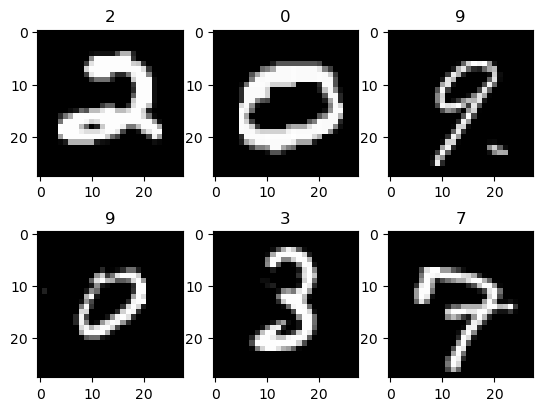

In [16]:
plt.figure()
f, axarr = plt.subplots(2, 3)
counter = 0
for i in range(2):
    for j in range(3):
        axarr[i][j].imshow(imgs[counter].squeeze(), cmap="gray")
        axarr[i][j].set_title(f"{labels[counter]}")
        counter += 1

In [17]:
submission_df = pd.DataFrame(list(zip(ids, labels)),
               columns =["ImageId", "Label"])
submission_df.to_csv("submission.csv", index=False)
submission_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
